# League Social Network using Reddit Comments
This notebook will create a social network consisting of champions that are mentioned in the same comment trees.

## Steps
1. Clean my data (trim new line characters, apostrophes, etc.)
2. Define regular expressions to use to search for occurrences of a particular champion mention. Some champions have nicknames and abbreviations that I want to account for.
3. For each comment tree, I'll create a list of champions that are mentioned within it.
4. Once I have this set of lists, I can create a count of occurrences of each unique combination and use that to create an adjacency matrix.
5. Finally, I can create my network from my adjacency matrix.

## Regular Expression (Cleaning)
First I'll clean up my data so I'm just working with words, separated by spaces. Note that this cleaning is really only meant to help with champion names (some other words will get distorted in process but I'm not too worried). 

In [101]:
import re
import json
from tqdm import tqdm_notebook
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

main_dict = json.load(open('thread_comments_25pg.txt'))

In [2]:
for thread, comments in main_dict.items():
    for i, tree in enumerate(comments):
        for j, comment in enumerate(tree): 
            comment = re.sub('(\'s)','',comment)
            comment = re.sub('[\n!?\"\'.,\\-/*\(\)]',' ',comment)
            main_dict[thread][i][j] = ' '+ comment + ' '

## RegEx (Champion Searching)
Now that the data is prepared, I'll create a regular expression pattern to search for which champions are mentioned in each tree. 

In the regular expression, I'm going to name my capture groups, and then I can easily access which groups were captured using the groupdict method. This will tell me what champions are mentioned in the trees. I'll later use these to build out my adjacency matrix.

I used the official website (http://gameinfo.na.leagueoflegends.com/en/game-info/champions/) as my reference, but will also include some common nicknames for the champions to try to capture them all (e.g. j4 for Jarvan IV).

In [3]:
# Create regular expression. I can shorten this by typing the champs in
# a list and then joining together into one long string.
champs = ['\s(?P<Aatrox>aatrox','Ahri>ahri','Akali>akali','Alistar>ali\s|alistar',
         'Amumu>mumu|amumu','Anivia>anivia','Annie>annia','Ashe>ashe\s','AurelionSol>aurelion|sol\s',
         'Azir>azir','Bard>bard','Blitzcrank>blitz','Brand>brand','Braum>braum',
         'Caitlyn>cait\s|caitlyn','Cassiopeia>cass\s|cassiopeia','ChoGath>cho\s|chogath',
         'Corki>corki','Darius>darius','Diana>diana','DrMundo>mundo\s','Draven>draven',
         'Ekko>ekko','Elise>elise','Eveleynn>eve\s|evelynn','Ezreal>ez\s|ezreal',
         'Fiddlesticks>fiddle\s|fiddlesticks','Fiora>fiora','Fizz>fizz','Galio>galio',
         'Gangplank>gp\s|gangplank','Garen>garen','Gnar>gnar','Gragas>grag','Graves>graves',
         'Hecarmin>hec\s|hecarim','Heimerdinger>heim\s|heimer|donger','Illaoi>illaoi',
         'Irelia>irelia','Janna>janna','JarvanIV>j4|jarvan|jiv\s','Jax>jax',
         'Jayce>jayce','Jhin>jhin','Jinx>jinx','Kalista>kalista','Karma>karma',
         'Karthus>karthus','Kassadin>kass\s|kassadin','Katarina>kat\s|katarina',
         'Kayle>kayle','Kennen>kennen','KhaZix>kha\s|khazix','Kindred>kindred',
         'Kled>kled',"KogMaw>kog\s|kogmaw",'LeBlanc>lb\s|leblanc','LeeSin>lee\s|leesin',
         'Leona>leona','Lissandra>liss\s|lissandra','Lucian>luc\s|lucian','Lulu>lulu',
         'Lux>lux','Malphite>malph\s|malphite','Malzahar>malz\s|malzahar','Maokai>mao\s|maokai',
         'MasterYi>yi\s','MissFortune>mf\s|miss\sfortune','Mordekaizer>morde\s|mordekaiser',
         'Morgana>morg\s|morgana','Nami>nami','Nasus>nasus|susan','Nautilus>naut\s|nautilus',
         'Nidalee>nid\s|nidalee','Nocturne>noct\s|nocturne','Nunu>nunu','Olaf>olaf',
         'Orianna>ori\s|orianna','Panthen>panth\s|pantheon','Poppy>poppy','Quinn>quinn',
         'Rammus>rammus','RekSai>rek\s|reksai','Renekton>renekton','Rengar>rengar|rengo',
         'Riven>riven','Rumble>rumble','Ryze>ryze','Sejuani>sej\s|sejuani','Shaco>shaco',
         'Shen>shen','Shyvana>shyv\s|shyvana','Singed>singed','Sion>sion','Sivir>sivir',
         'Skarner>skarner','Sona>sona','Soraka>raka\s|soraka','Swain>swain','Syndra>syndra',
         'TahmKench>tk\s|tahm\s|kench\s','Taliyah>taliyah','Talon>talon','Taric>taric',
         'Teemo>teemo|satan','Thresh>thresh','Tristana>trist\s|tristana','Trundle>trundle',
         'Tryndamere>tryn\s|trynd\s|trynda\s|tryndamere','TwistedFate>tf\s|twisted\sfate',
         'Twitch>twitch','Udyr>udyr','Urgot>urgot','Varus>varus','Vayne>vayne','Veigar>veig\s|veigar',
         'VelKoz>vel\s|koz\s|velkoz','Vi>vi\s','Viktor>vik\s|viktor','Vladimir>vlad\s|vladimir',
         'Volibear>voli\s|volibear','Warwick>ww\s|warwick','Wukong>wu\s|wukong',
         'Xerath>xerath','XinZhao>xin\s|xinzhao','Yasuo>yas\s|yasuo','Yorick>yorick',
         'Zac>zac','Zed>zed','Ziggs>ziggs','Zilean>zilean','Zyra>zyra)']

# I save typing by joining on the shared regex characters, and then I can split them back out and create a separate
# RegEx object for each champion.
champ_patterns = [re.compile(champ) for champ in ").+?,\s(?P<".join(champs).split(",")]

In [4]:
champion_mentions = {}
for each in champ_patterns:
    for k,v in each.groupindex.items():
        champion_mentions.setdefault(k,0)

In [5]:
champ_list = []
check_matches = {}

In [6]:
for thread, comments in tqdm_notebook(main_dict.items(),desc='Threads',leave=False):
    for tree in tqdm_notebook(comments,desc='Trees',leave=False):
        temp = []
        matches = [champ.search(str(tree)) for champ in champ_patterns]
        for match in matches:
            if match!=None:
                for k,v in match.groupdict().items():
                    temp.append(k)
                    check_matches.setdefault(k,[]).append(v)
        if len(temp):
            champ_list.append(temp)

In [7]:
for k,v in check_matches.items():
    check_matches[k] = set(v)

check_matches

{'Aatrox': {'aatrox'},
 'Ahri': {'ahri'},
 'Akali': {'akali'},
 'Alistar': {'ali ', 'alistar'},
 'Amumu': {'amumu', 'mumu'},
 'Anivia': {'anivia'},
 'Ashe': {'ashe '},
 'AurelionSol': {'aurelion', 'sol '},
 'Azir': {'azir'},
 'Bard': {'bard'},
 'Blitzcrank': {'blitz'},
 'Brand': {'brand'},
 'Braum': {'braum'},
 'Caitlyn': {'cait ', 'caitlyn'},
 'Cassiopeia': {'cass ', 'cassiopeia'},
 'ChoGath': {'cho ', 'chogath'},
 'Corki': {'corki'},
 'Darius': {'darius'},
 'Diana': {'diana'},
 'DrMundo': {'mundo '},
 'Draven': {'draven'},
 'Ekko': {'ekko'},
 'Elise': {'elise'},
 'Eveleynn': {'eve ', 'evelynn'},
 'Ezreal': {'ez ', 'ezreal'},
 'Fiddlesticks': {'fiddle ', 'fiddlesticks'},
 'Fiora': {'fiora'},
 'Fizz': {'fizz'},
 'Galio': {'galio'},
 'Gangplank': {'gangplank', 'gp '},
 'Garen': {'garen'},
 'Gnar': {'gnar'},
 'Gragas': {'grag'},
 'Graves': {'graves'},
 'Hecarmin': {'hec ', 'hecarim'},
 'Heimerdinger': {'donger', 'heim ', 'heimer'},
 'Illaoi': {'illaoi'},
 'Irelia': {'irelia'},
 'Janna': 

Good, we aren't picking up any false positives.

Now I need to generate my combinations of champions so I can calculate the edges between nodes. I also want to tally up individual champions to gauge overall popularity.

In [46]:
combos = []
for tree in champ_list:
    temp = [comb for comb in combinations(tree,2)]
    if type(temp)!=None:
        combos.extend(temp)

In [49]:
combos[1:10]

[('Janna', 'Riven'),
 ('Amumu', 'Kennen'),
 ('LeeSin', 'MasterYi'),
 ('Fizz', 'Skarner'),
 ('Diana', 'Gragas'),
 ('Diana', 'Hecarmin'),
 ('Diana', 'LeeSin'),
 ('Diana', 'Sejuani'),
 ('Diana', 'Shyvana')]

This is exactly what we want, and now we can use this to create our adjacency matrix

In [50]:
matrix = defaultdict(int)
for edge in combos:
    matrix[edge]+=1

In [58]:
for k,v in matrix.items():
    print(k,v)

('Syndra', 'Volibear') 1
('Kled', 'Olaf') 2
('AurelionSol', 'Caitlyn') 1
('Fiddlesticks', 'Zilean') 2
('Karma', 'Quinn') 7
('Amumu', 'Zyra') 6
('Skarner', 'Tryndamere') 3
('Braum', 'Nami') 23
('Kassadin', 'Orianna') 6
('Janna', 'Orianna') 1
('Lucian', 'Ziggs') 2
('Anivia', 'Vladimir') 10
('Galio', 'Kalista') 2
('Vi', 'Viktor') 4
('Akali', 'Gragas') 5
('Sion', 'Tryndamere') 6
('Garen', 'Jinx') 1
('Gnar', 'Sion') 6
('Shaco', 'Tristana') 2
('RekSai', 'Warwick') 6
('Ryze', 'Warwick') 5
('Hecarmin', 'Orianna') 4
('Corki', 'Shaco') 3
('Karma', 'Malphite') 9
('Heimerdinger', 'Malzahar') 2
('Akali', 'Talon') 6
('Rumble', 'Sona') 1
('Heimerdinger', 'Viktor') 5
('Karma', 'Wukong') 6
('MissFortune', 'Singed') 1
('Anivia', 'Volibear') 2
('Eveleynn', 'Ryze') 2
('Ashe', 'Katarina') 6
('Kled', 'Varus') 1
('Amumu', 'Lux') 8
('Panthen', 'VelKoz') 3
('Akali', 'MasterYi') 2
('Varus', 'Warwick') 1
('Poppy', 'Talon') 2
('Poppy', 'Shyvana') 1
('Nami', 'Poppy') 2
('Amumu', 'Thresh') 5
('Lissandra', 'Twitch')

In [78]:
G = nx.Graph()
for k,v in matrix.items():
    G.add_edge(k[0],k[1],weight=v)

<IPython.core.display.Javascript object>


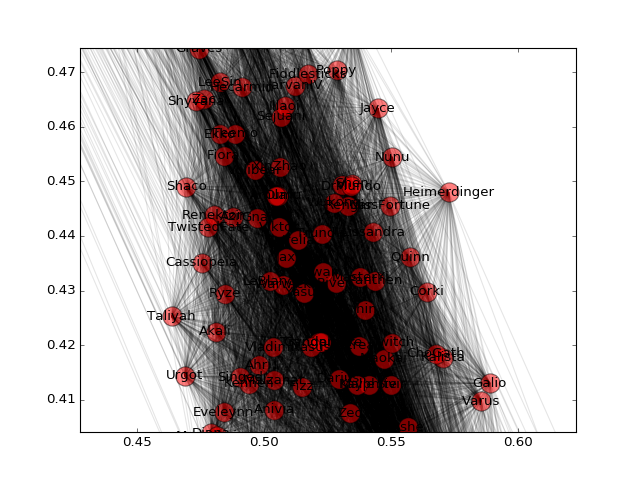

In [102]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,alpha=0.5)
nx.draw_networkx_edges(G,pos,alpha=0.1)
nx.draw_networkx_labels(G,pos)
plt.show()

So this is good, but a little tough to visualize, so what I'm thinking is I'll set a minimum number of mentions, e.g. need to have matched more than 5 times. This should also allow us to see stronger and more distinct clusters. I initially thought that simply weighting the edges would account for this, but I think the result is that there are simply too many edges to really see what is going on.